In [2]:
import pandas as pd
import boto3

bucket = 'facebook-analysis'
file_key = 'campaigns/campaigns.csv'  # adjust path if needed

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=file_key)
df_campaigns = pd.read_csv(obj['Body'])

df_campaigns.head()



,ad_id,ad_category,ad_platform,ad_type,ad_spend,revenue,roi
0,A0001,Sportswear,Facebook,Image,0.09,0.00,-1.00
1,A0002,Electronics,Facebook,Image,0.27,62.00,228.63
2,A0003,Luggage,Instagram,Image,0.52,76.48,146.08
3,A0004,Gadgets,Facebook,Video,0.42,0.00,-1.00
4,A0005,Luggage,Instagram,Carousel,0.40,0.00,-1.00


In [3]:
import pandas as pd
import boto3

bucket = 'facebook-analysis'

# File paths in S3
campaigns_key = 'campaigns/campaigns.csv'
users_key = 'users/users.csv'
journey_key = 'customer_journey/customer_journey.csv'

# Create S3 client
s3 = boto3.client('s3')

# Load files
df_campaigns = pd.read_csv(s3.get_object(Bucket=bucket, Key=campaigns_key)['Body'])
df_users = pd.read_csv(s3.get_object(Bucket=bucket, Key=users_key)['Body'])
df_journey = pd.read_csv(s3.get_object(Bucket=bucket, Key=journey_key)['Body'])

# Quick check
df_campaigns.head(), df_users.head(), df_journey.head()


(   ad_id  ad_category ad_platform   ad_type  ad_spend  revenue     roi
 0  A0001   Sportswear    Facebook     Image      0.09     0.00   -1.00
 1  A0002  Electronics    Facebook     Image      0.27    62.00  228.63
 2  A0003      Luggage   Instagram     Image      0.52    76.48  146.08
 3  A0004      Gadgets    Facebook     Video      0.42     0.00   -1.00
 4  A0005      Luggage   Instagram  Carousel      0.40     0.00   -1.00,
   user_id  age gender location interests device_type
 0   U0001   58      M      USA      Food      Mobile
 1   U0002   55      F      USA      Tech      Tablet
 2   U0003   52      F       UK    Gaming      Mobile
 3   U0004   31      F      USA      Tech     Desktop
 4   U0005   52      M    India      Tech      Tablet,
   user_id  ad_id  impressions  clicks  conversion  time_spent_on_ad  \
 0   U0001  A0001            3       0           0              3.38   
 1   U0002  A0002            9       9           1              6.77   
 2   U0003  A0003         

In [4]:
# Merge journey + users
df_merged = df_journey.merge(df_users, on='user_id', how='left')

# Merge with campaigns
df_merged = df_merged.merge(df_campaigns, on='ad_id', how='left')

# Preview final dataset
df_merged.head()


,user_id,ad_id,impressions,clicks,conversion,time_spent_on_ad,day_of_week,engagement_score,age,gender,location,interests,device_type,ad_category,ad_platform,ad_type,ad_spend,revenue,roi
0,U0001,A0001,3,0,0,3.38,Friday,0.02,58,M,USA,Food,Mobile,Sportswear,Facebook,Image,0.09,0.00,-1.00
1,U0001,A0001,3,0,0,3.38,Friday,0.02,58,M,USA,Food,Mobile,Sportswear,Instagram,Video,0.56,0.00,-1.00
2,U0001,A0001,3,0,0,3.38,Friday,0.02,58,M,USA,Food,Mobile,Sportswear,Facebook,Video,0.18,0.00,-1.00
3,U0001,A0001,3,0,0,3.38,Friday,0.02,58,M,USA,Food,Mobile,Luggage,Facebook,Video,0.42,28.00,65.67
4,U0001,A0001,3,0,0,3.38,Friday,0.02,58,M,USA,Food,Mobile,Luggage,Facebook,Image,0.09,51.96,576.33


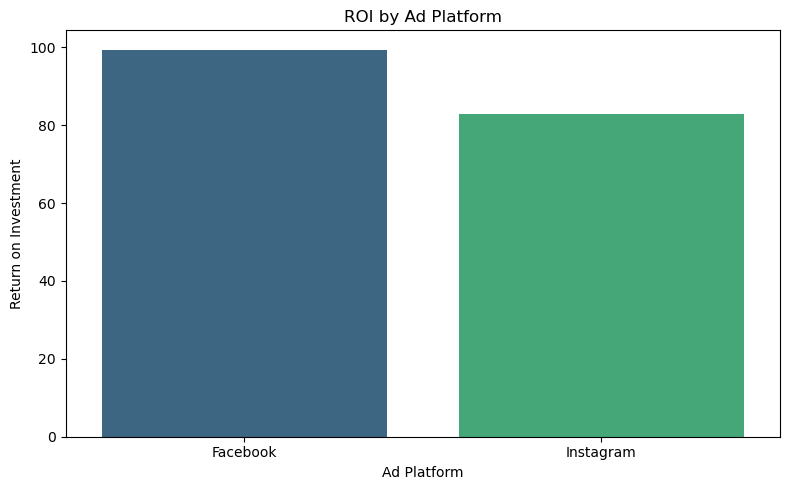

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

roi_data = df_campaigns.groupby('ad_platform').agg(
    total_revenue=('revenue', 'sum'),
    total_spend=('ad_spend', 'sum')
).reset_index()

roi_data['ROI'] = roi_data['total_revenue'] / roi_data['total_spend']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=roi_data, x='ad_platform', y='ROI', hue='ad_platform', palette='viridis', legend=False)
plt.title('ROI by Ad Platform')
plt.ylabel('Return on Investment')
plt.xlabel('Ad Platform')
plt.tight_layout()
plt.show()


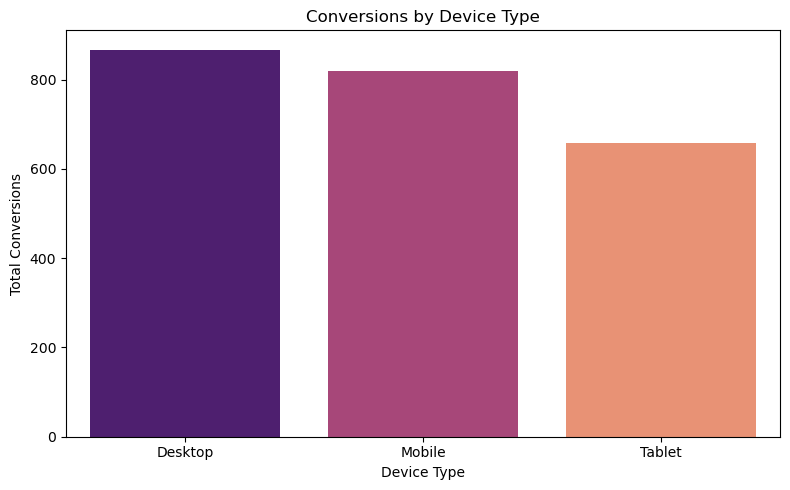

In [8]:
device_metrics = df_merged.groupby('device_type').agg(
    impressions=('impressions', 'sum'),
    clicks=('clicks', 'sum'),
    conversions=('conversion', 'sum')
).reset_index()

device_metrics['CTR'] = 100 * device_metrics['clicks'] / device_metrics['impressions']

# Plot conversions
plt.figure(figsize=(8, 5))
sns.barplot(data=device_metrics, x='device_type', y='conversions', hue='device_type', palette='magma', legend=False)
plt.title('Conversions by Device Type')
plt.ylabel('Total Conversions')
plt.xlabel('Device Type')
plt.tight_layout()
plt.show()


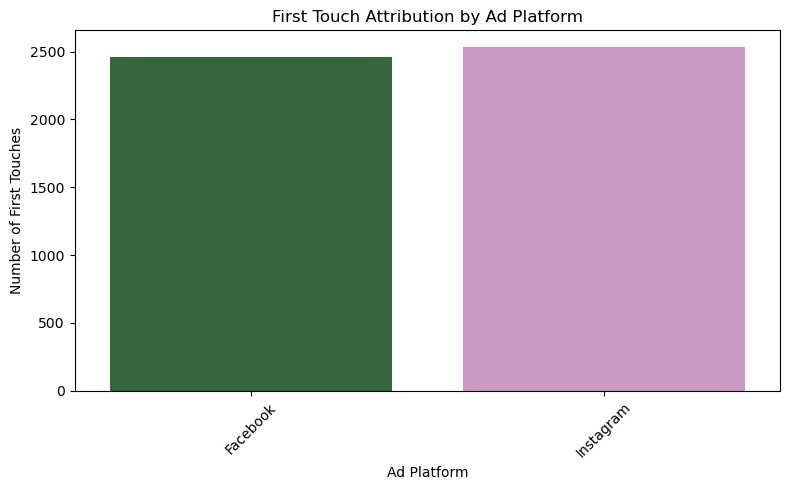

In [14]:
# STEP 1: Sort by user_id and day_of_week 
df_journey_sorted = df_journey.sort_values(['user_id', 'day_of_week'])

# STEP 2: Keep only the first interaction per user
first_touch = df_journey_sorted.drop_duplicates(subset='user_id', keep='first').copy()

# STEP 3: Merge with campaign data to bring in ad_platform info
first_touch_summary = first_touch.merge(df_campaigns, on='ad_id', how='left')

# STEP 4: Plot first-touch attribution by ad platform
plt.figure(figsize=(8, 5))
sns.countplot(data=first_touch_summary, x='ad_platform', hue='ad_platform', palette='cubehelix', legend=False)
plt.title('First Touch Attribution by Ad Platform')
plt.xlabel('Ad Platform')
plt.ylabel('Number of First Touches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


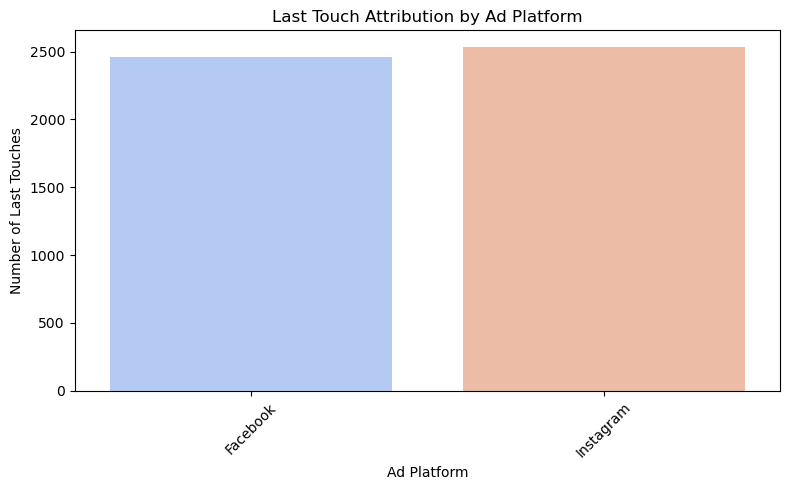

In [15]:
# STEP 1: Sort by user_id and day_of_week (latest interaction comes last)
df_journey_sorted = df_journey.sort_values(['user_id', 'day_of_week'])

# STEP 2: Keep only the last interaction per user
last_touch = df_journey_sorted.drop_duplicates(subset='user_id', keep='last').copy()

# STEP 3: Merge with campaign data to bring in ad_platform info
last_touch_summary = last_touch.merge(df_campaigns, on='ad_id', how='left')

# STEP 4: Plot last-touch attribution by ad platform
plt.figure(figsize=(8, 5))
sns.countplot(data=last_touch_summary, x='ad_platform', hue='ad_platform', palette='coolwarm', legend=False)
plt.title('Last Touch Attribution by Ad Platform')
plt.xlabel('Ad Platform')
plt.ylabel('Number of Last Touches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clustering for Audience Segmentation

1. Select Features for Clustering

In [16]:
# Select features for clustering
cluster_df = df_merged[['user_id', 'age', 'impressions', 'clicks', 'conversion']]

# Drop rows with missing values
cluster_df = cluster_df.dropna()

2. Preprocess: Normalize/Scale Features

In [17]:
from sklearn.preprocessing import StandardScaler

features = ['age', 'impressions', 'clicks', 'conversion']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df[features])

3. Apply KMeans Clustering

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(scaled_features)

4. Analyze Cluster Profiles

In [19]:
cluster_profiles = cluster_df.groupby('cluster')[features].mean().round(2)
print(cluster_profiles)

           age  impressions  clicks  conversion
cluster                                        
0        39.90         6.14    1.77        0.00
1        38.68         6.85    3.33        1.00
2        39.60        12.22    8.91        0.45


5. Visualize the Clusters

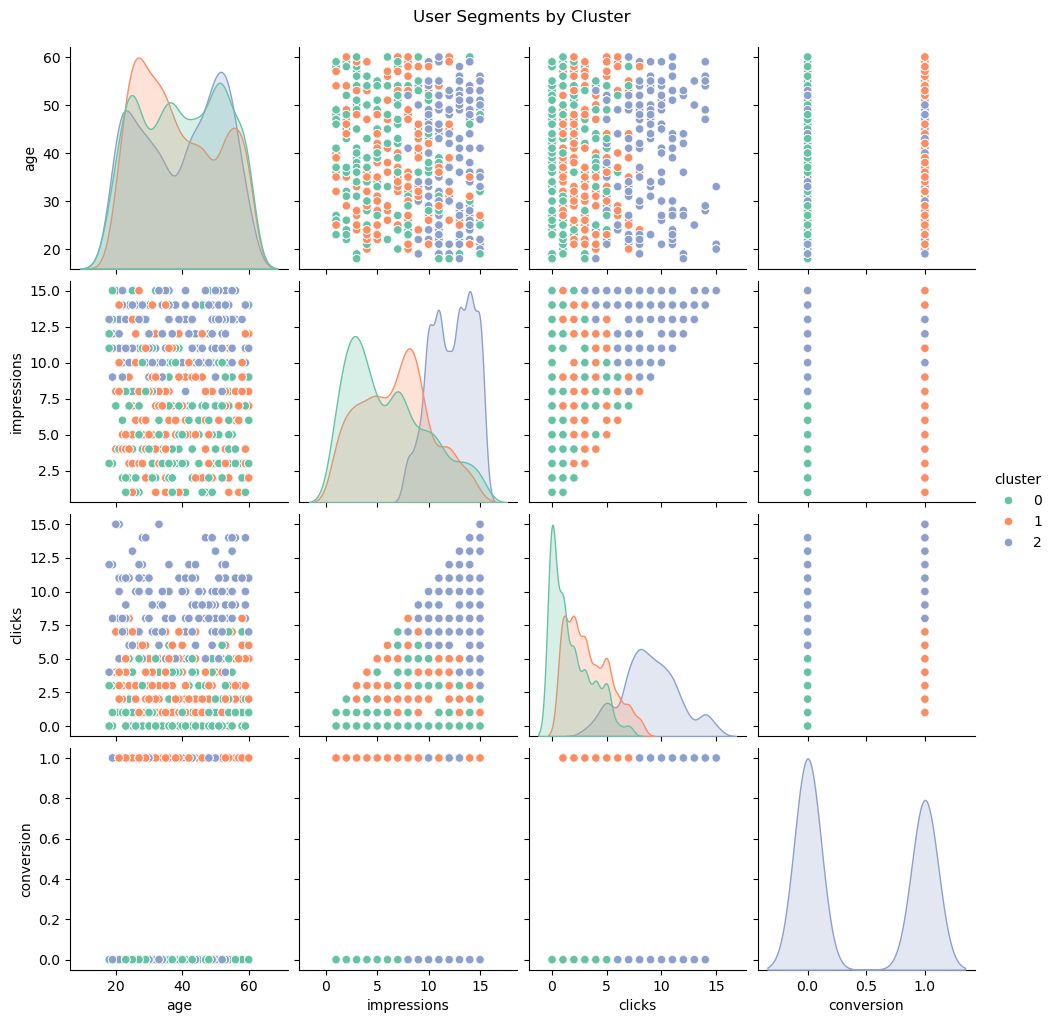

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Quick visualization using pairplot
sns.pairplot(cluster_df, hue='cluster', diag_kind='kde', palette='Set2')
plt.suptitle('User Segments by Cluster', y=1.02)
plt.show()

Interpretation Examples:

->Cluster 0: Young users with high impressions but low conversions

->Cluster 1: Older users with high conversion rates

->Cluster 2: Low-engagement users